# Construção da base

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

In [2]:
# número de linhas na base
n = 150

________
### Base de gastos

__Coluna de datas__

In [3]:
# criando série de datas aleatórios em janeiro
# https://stackoverflow.com/questions/50559078/generating-random-dates-within-a-given-range-in-pandas

def random_dates(start, end, n, unit='D'):

    ndays = (end - start).days + 1
    
    dates = pd.to_timedelta(np.random.rand(n) * ndays, unit=unit) + start
    
    return pd.Series(dates).sort_values().apply(lambda x: x.date()).reset_index(drop=True)

np.random.seed(42)
start = pd.to_datetime('2021-01-01')
end = pd.to_datetime('2021-01-31')

# série de datas aleatórias, ordenadas
dates = random_dates(start, end, n)

# deixa no formato br
dates = dates.apply(lambda x: dt.datetime.strftime(x, "%d-%m-%y"))

dates

0      01-01-21
1      01-01-21
2      01-01-21
3      01-01-21
4      01-01-21
         ...   
145    30-01-21
146    31-01-21
147    31-01-21
148    31-01-21
149    31-01-21
Length: 150, dtype: object

__Coluna de nome de clientes__

In [4]:
# alguns dos nomes mais comuns no brasil https://pt.wikipedia.org/wiki/Lista_de_prenomes_mais_comuns_no_Brasil

nomes1 = "João José Antônio Francisco Carlos Pedro Paulo Lucas Luiz Marcos".split()
nomes2 = "Maria Ana Adriana Juliana Márcia Fernanda Patrícia Aline Sandra Camila".split()

# série de nomes completa
nomes_inicial = pd.Series(nomes1 + nomes2)

# sobrenomes mais comuns
# https://www.maioresemelhores.com/sobrenomes-mais-comuns-no-brasil/
sobrenomes = "Silva Santos Oliveira Souza Rodrigues Oliveira Alves Pereira Lima Gomes Costa Ribeira Martins".split()
sobrenomes = pd.Series(sobrenomes).sample(nomes_inicial.shape[0], replace=True).reset_index(drop=True)

# juntando nomes e sobrenomes
nomes_inicial = nomes_inicial + " " + sobrenomes

# série de nomes amostrados aleatoriamente
nomes = nomes_inicial.sample(n, random_state=42, replace=True).reset_index(drop=True)

# check - tudo bem se tiver mais operações de certos clientes
display(nomes.value_counts())

nomes.value_counts().sum() == n

Paulo Gomes          14
Márcia Silva         12
Ana Costa            11
Antônio Oliveira     10
Lucas Oliveira       10
João Silva            9
Luiz Alves            8
Adriana Pereira       8
Francisco Santos      8
José Silva            7
Sandra Souza          6
Camila Santos         6
Maria Alves           6
Marcos Souza          6
Juliana Costa         6
Carlos Rodrigues      6
Aline Rodrigues       5
Pedro Ribeira         4
Fernanda Oliveira     4
Patrícia Pereira      4
dtype: int64

True

__Colunas de gastos e número de parcelas__

count     150.000000
mean      718.019400
std       646.223867
min        63.880000
25%       324.227500
50%       540.885000
75%       851.025000
max      4398.000000
dtype: float64

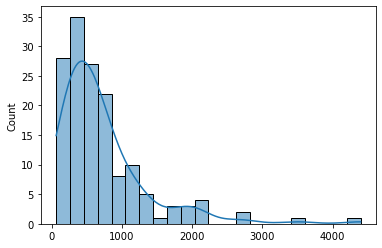

count    150.000000
mean       3.793333
std        2.329550
min        1.000000
25%        2.000000
50%        4.000000
75%        5.000000
max       11.000000
dtype: float64

In [5]:
# gerando distribuição log-normal com média e std 1k
# tem que corrigir os parâmetros 
# vide https://stackoverflow.com/questions/51609299/python-np-lognormal-gives-infinite-results-for-big-average-and-st-dev

mu, sigma = 0.8e3, 0.8e3

# corrigindo os parâmetros
normal_std = np.sqrt(np.log(1 + (sigma/mu)**2))
normal_mean = np.log(mu) - normal_std**2 / 2

# criando a série
# arredonda pra duas casas decimais
np.random.seed(42)
gastos = pd.Series(np.random.lognormal(normal_mean, 
                                       normal_std, 
                                       n)).apply(lambda x: round(float(x), 2))

# pra deixar mais realístico, vamos deixar 40% dos gastos como números inteiros
ints = gastos.sample(frac=0.4).apply(lambda x: round(x, 0))
gastos.loc[ints.index] = ints

# check.. média e std próximos de 1k
display(gastos.describe())

# tem que se parecer com uma log-normal
sns.histplot(gastos, kde=True)
plt.show()

#########################################################################################

# número de parcelas
# se gasto for menor que 100 reais, uma parcela
# se for entre 100 e a média (1e3), parcela aleatória entre 1 e 5
# se for maior que a média, parcela entre 1 e 11 (não 12 vezes pra não passar do ano)
parcelas = gastos.apply(lambda x: 
                        1 if x < 100 else
                        (np.random.randint(1, 6) if x < mu else np.random.randint(1, 12)))

display(parcelas.describe())

# #########################################################################################

# pra dificultar rsrs
gastos.loc[ints.index] = gastos.loc[ints.index].apply(lambda x: str(x) + "0")
gastos = gastos.apply(lambda x: "R$ " + str(x)).apply(lambda x: x.replace(".", ","))

In [6]:
# construindo o dataframe

df_gastos = pd.DataFrame()

df_gastos["nm_cliente"] = nomes

df_gastos["valor_operacao"] = gastos

df_gastos["num_parcelas"] = parcelas

df_gastos["dt_operacao"] = dates

# pra dificultar hehe
df_gastos["mes_atual"] = "jan/21"

df_gastos

,nm_cliente,valor_operacao,num_parcelas,dt_operacao,mes_atual
0,Paulo Gomes,"R$ 855,00",5,01-01-21,jan/21
1,Camila Santos,"R$ 504,18",2,01-01-21,jan/21
2,Márcia Silva,"R$ 970,00",5,01-01-21,jan/21
3,Maria Alves,"R$ 2010,31",7,01-01-21,jan/21
4,Lucas Oliveira,"R$ 465,00",1,01-01-21,jan/21
...,...,...,...,...,...
145,Adriana Pereira,"R$ 1084,58",10,30-01-21,jan/21
146,Luiz Alves,"R$ 202,00",5,31-01-21,jan/21
147,Antônio Oliveira,"R$ 188,42",5,31-01-21,jan/21
148,Paulo Gomes,"R$ 874,00",3,31-01-21,jan/21


______
### Base de limites

In [7]:
# pra começar, vamos mexer um pouco na série de nomes

# primeira coisa, vamos botar espaços extras no começo e no final
nomes_final = " " + nomes_inicial + "    "

# vamos escolher alguns nomes pra deixar em maiúscula
maiuscula = nomes_final.sample(frac=0.4).apply(lambda x: x.upper())
nomes_final.loc[maiuscula.index] = maiuscula

# vamos escolher alguns nomes pra deixar no formato sobrenome, nome
invertido = nomes_final.sample(frac=0.3).apply(lambda x: x.split()[1] + ", " + x.split()[0])
nomes_final.loc[invertido.index] = invertido

nomes_final

0                SILVA, JOÃO
1             JOSÉ SILVA    
2       Antônio Oliveira    
3          Santos, Francisco
4          Rodrigues, Carlos
5          PEDRO RIBEIRA    
6            Paulo Gomes    
7         LUCAS OLIVEIRA    
8             LUIZ ALVES    
9           Marcos Souza    
10           MARIA ALVES    
11             ANA COSTA    
12       Adriana Pereira    
13            Costa, Juliana
14             Silva, Márcia
15     Fernanda Oliveira    
16      Patrícia Pereira    
17          Rodrigues, Aline
18          SANDRA SOUZA    
19         Camila Santos    
dtype: object

In [8]:
# limites, bem simples

np.random.seed(42)
limites = pd.Series(np.random.randint(1, 225, nomes_final.shape[0])*25)

limites = limites.apply(lambda x: "R$ " + str(x) + ",00")

In [9]:
# datas de fechamento

fechamento = pd.Series(pd.to_datetime(['2021-01-05', 
                                      '2021-01-15', 
                                      '2021-01-25'])).sample(nomes_final.shape[0],
                                                             replace=True,
                                                             random_state=42).reset_index(drop=True)

fechamento = fechamento.apply(lambda x: dt.datetime.strftime(x, "%d-%m-%y"))

In [10]:
df_limites = pd.DataFrame()

# nome diferente de coluna
df_limites["cliente"] = nomes_final

df_limites["limite"] = limites

df_limites["dt_fechamento"] = fechamento

df_limites

,cliente,limite,dt_fechamento
0,"SILVA, JOÃO","R$ 2575,00",25-01-21
1,JOSÉ SILVA,"R$ 4500,00",05-01-21
2,Antônio Oliveira,"R$ 2325,00",25-01-21
3,"Santos, Francisco","R$ 375,00",25-01-21
4,"Rodrigues, Carlos","R$ 2675,00",05-01-21
5,PEDRO RIBEIRA,"R$ 1800,00",05-01-21
6,Paulo Gomes,"R$ 4725,00",25-01-21
7,LUCAS OLIVEIRA,"R$ 525,00",15-01-21
8,LUIZ ALVES,"R$ 2575,00",25-01-21
9,Marcos Souza,"R$ 3050,00",25-01-21


__Exportando as bases__

In [11]:
with pd.ExcelWriter("gastos_limites.xlsx") as writer:
    
    df_gastos.to_excel(writer, sheet_name = "gastos")
    
    df_limites.to_excel(writer, sheet_name = "limites")